# Implementation

In the previous code, I have implemented all the tools needed to make a fully automised monthly report maker (except for the mailing part). There are several main goals to achieve with this function:

1. Data treatment (NaNs esp)
2. Creation of relevant numbers and graphs
3. Creation of word document
4. Saving word document report and graphs in a dedicated folder

For every CPO that needs a report.

### CPO reports

There are 2 types of CPOs: EZ drive and Non-EZ drive

All reports need:

**Numbers**
-Nombre de points de charges
-Nombres de recharges mensuel
-Temps moyen d'une charge (min)
-Consommation Mensuelle (kWh)

**Graphs**
-Daily number of charges
-Daily amount of charges

**Non EZ-drive**
Estimation cout mensuel

**EZ-drive**
Retribution sur l'energie consommee




## 1. Read and treat database

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from docx import Document
import os
import datetime
import time

In [ ]:
#enter dates of report
month = '08'
year = '2022'
date_start = '01'
date_end = '31'

charge_events_filename = 'cpochargeevents_'+date_start+'.'+month+'.'+year+' - '+date_end+'.'+month+'.'+year+'.csv'
charge_events = pd.read_csv(charge_events_filename,skiprows=1) #load the csv charge events file into pandas dataframe
charge_events['Energy (Wh)'] = charge_events['Energy (Wh)']/1000 #change Wh to kWh
charge_events.rename(columns = {'Energy (Wh)':'Energy (kWh)'})
time_24 = ['Created','Stop time','Start time']
charge_events[time_24] = charge_events[time_24].apply(pd.to_datetime,format = '%Y-%m-%d %H:%M:%S') #apply date time format to columns w dates
missing_stop_time_idx = np.where(charge_events['Stop time'].isnull())
charge_events['Stop time'].loc[missing_stop_time_idx] = charge_events['Start time'].loc[missing_stop_time_idx]+timedelta(hours=1) #adding 1 hour to NaN values
charge_events['Date'] = charge_events['Start time'].dt.date #create a new column with just the date of the start of the charge




/home/stella/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


## 2. Groupby - for every CPO, generate the necessary data for the report

Loop for every unique CPO name to create and save the two graphs and report.


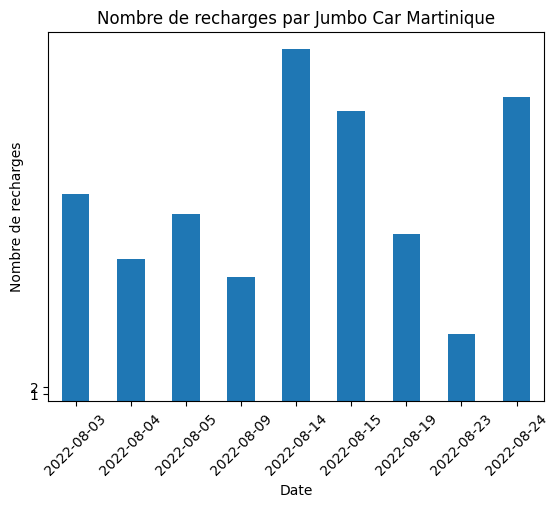

In [ ]:

test_CPO = charge_events.groupby(['CPO name']).get_group(test) #get the info for a single CPO
test_CPO_energy = test_CPO.groupby('Date')['Energy (Wh)'].sum()#sum all the energy used by this cpo for each date he/she recharged 
test_CPO_count = test_CPO.groupby('Date')['Charge ID'].count()#count each time they used a borne for every date

#plot daily energy bar chart
bar_energy = test_CPO_energy.plot(kind= 'bar')
bar_energy.set_ylabel('Energy (Wh)')
bar_energy.set_title('Energie consommee par '+ test)
bar_energy.set_xticklabels(pd.to_datetime(test_CPO_energy.index).date,rotation = 45)

#plot daily usage count bar chart
bar_count = test_CPO_count.plot(kind='bar')
bar_count.set_ylabel('Nombre de recharges')
bar_count.set_title('Nombre de recharges par '+ test)
bar_count.set_xticklabels(pd.to_datetime(test_CPO_energy.index).date,rotation = 45)
bar_count.set_yticks(test_CPO_count.unique())

#get other relevant information needed for the report
retribution = 1 
no_de_points = len(test_CPO['Station ID'].unique())
no_de_recharges_mensuels = test_CPO_count.sum()
temps_moyen_de_charge = test_CPO['Duration'].mean()
conso_total = test_CPO_energy.sum()